# Piecewise Linear Regression Using a Mixed Integer Linear Program
_Daniyar Akizhanov_

## Required imports

Besides the imports below, please install the glpk solver and add it to the path. For more information, refer to pyomo documentation.

In [13]:
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt

## Abstract Model Construction

In [14]:
model = pyo.AbstractModel()

# Number of sample points & iterator for them
model.n = pyo.Param(within=pyo.NonNegativeIntegers)
model.I = pyo.RangeSet(1, model.n)

# Number of segments & iterator for them
model.m = pyo.Param(within=pyo.NonNegativeIntegers)
model.J = pyo.RangeSet(1, model.m)

# The sample data
model.X = pyo.Param(model.I, domain=pyo.Reals)
model.Y = pyo.Param(model.I, domain=pyo.Reals)

# big M for deviation [abs(y - kx - b)] values
model.bigM = pyo.Param(domain = pyo.NonNegativeReals)

# B[i,j] indicates that point i is in segment s <= j
model.B = pyo.Var(model.I, model.J, domain=pyo.Binary)
# deviation: abs(y - kx - b)
model.d = pyo.Var(model.I, domain=pyo.NonNegativeReals)
# y = kx + b
model.k = pyo.Var(model.J, domain=pyo.Reals)
model.b = pyo.Var(model.J)

In [15]:
def obj_expression(m):
    return pyo.summation(m.d)

model.OBJ = pyo.Objective(rule=obj_expression)

def fillLastRule(m, i):
    return (m.B[i,m.m] == 1)

model.fillLastConst = pyo.Constraint(model.I, rule = fillLastRule)

def fillOneRule(m, j):
    return (m.B[1,j] == 1)

model.fillOneConst = pyo.Constraint(model.J, rule = fillOneRule)

def includesLastRule(m, i, j):
    return (m.B[i,j] >= m.B[i,j-1])

J2 = pyo.RangeSet(2, model.m)
model.inclLastConst = pyo.Constraint(model.I, J2, rule = includesLastRule)

def solidRule(m, i, j):
    return (m.B[i,j] <= m.B[i-1,j])

I2 = pyo.RangeSet(2, model.n)
model.solidConst = pyo.Constraint(I2, model.J, rule = solidRule)

def devPosRule(m, i, j):
    return (-m.bigM * (1 - m.B[i, j] + m.B[i,j-1]) + m.X[i]*m.k[j] + m.b[j] - m.Y[i] <= m.d[i])

model.devPosConst = pyo.Constraint(model.I, J2, rule = devPosRule)

def devPosFirstRule(m, i):
    return (-m.bigM * (1 - m.B[i, 1]) + m.X[i]*m.k[1] + m.b[1] - m.Y[i] <= m.d[i])

model.devPosFirstConst = pyo.Constraint(model.I, rule = devPosFirstRule)

def devNegRule(m, i, j):
    return (-m.bigM * (1 - m.B[i, j] + m.B[i,j-1]) - m.X[i]*m.k[j] - m.b[j] + m.Y[i] <= m.d[i])

model.devNegConst = pyo.Constraint(model.I, J2, rule=devNegRule)

def devNegFirstRule(m, i):
    return (-m.bigM * (1 - m.B[i, 1]) - m.X[i]*m.k[1] - m.b[1] + m.Y[i] <= m.d[i])

model.devNegFirstConst = pyo.Constraint(model.I, rule = devNegFirstRule)

## Concrete Model Construction

We'll approximate the arctan function.

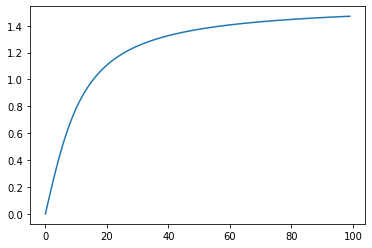

In [16]:
X = np.arange(100)
y = np.arctan(X / 10)
plt.plot(X, y)

In [17]:
params = dict()
params['n'] = {None : X.shape[0]}
params['m'] = {None : 4}
Xlist = X.tolist()
params['X'] = {i+1 : Xlist[i] for i in range(len(Xlist))}
ylist = y.tolist()
params['Y'] = {i+1 : ylist[i] for i in range(len(ylist))}
# Attention: big M has to be tuned for every problem.
params['bigM'] = {None : 100}
params = {None : params}

In [18]:
instance = model.create_instance(params)

## Solving the Mixed Integer Linear Program

In [19]:
opt = pyo.SolverFactory('glpk')
solution = opt.solve(instance)

## Interpreting the Optimal Solution

In [20]:
B_dict = instance.B.get_values()
X_inds = np.zeros((X.shape[0], instance.m.value), bool)
for i in range(100):
    if B_dict[(i+1, 1)] == 1:
        X_inds[i,0] = True
        continue
    for j in range(2, instance.m.value + 1):
        if B_dict[(i+1, j)] - B_dict[(i+1, j-1)] == 1:
            X_inds[i,j-1] = True
            break

In [21]:
X_inds[:,0].sum()

10

In [22]:
k = instance.k.get_values()
b = instance.b.get_values()

In [23]:
k, b

({1: 0.0826660809078646,
  2: 0.0274354310343889,
  3: 0.00717337808498214,
  4: 0.00181891271552672},
 {1: 0.0320633980341512,
  2: 0.558440097106311,
  3: 1.0338444298488,
  4: 1.29811061527402})

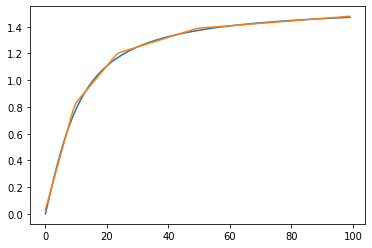

In [25]:
plt.plot(X, y)
y_pred = np.zeros(y.shape)
for j in range(instance.m.value):
    y_pred += X_inds[:,j] * (k[j+1] * X + b[j+1])
plt.plot(X, y_pred)